In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
#from datetime import timedelta
import matplotlib as mpl

#from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D


#from time import time
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

Notice: This notebook is 'collage' and adaptation of several (note)books that can be found online.
The purpose is merely educational.
References:
https://otexts.com/fpp3/
https://neptune.ai/blog/anomaly-detection-in-time-series

One can broadly distinguish between two types of outliers. Those that are interesting for our analysis, and those that are irrelevant. This classificiation will obviously depend on the task at hand.

The irrelevant data points, which may come from an irrelevant glitch in the data collection process, are usually simply discarded. However, if those points are instead quite relevant to our analysis, we must instead preserve and analyse them.

# Importing Catfish Data

In [2]:
#read data
catfish_sales = pd.read_csv(os.path.join("Anomaly Detection - Neptune.ai",'catfish.csv'),
                            index_col=0,infer_datetime_format=True,parse_dates=True)

In [3]:
catfish_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 324 entries, 1986-01-01 to 2012-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Total   324 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB


In [4]:
pd.infer_freq(catfish_sales.index)
# MS - Month Start
# Pandas automatically recognized the datetime index structure

'MS'

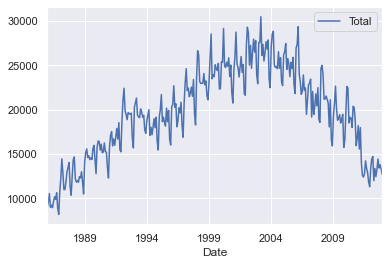

In [5]:
catfish_sales.plot();
# time period is too big, for a realistic analysis.
# we should consider restraining ourselves to a smaller time span

# Creating point anomalies (local and global)

In [6]:
# first don't change the original df

catfish_anom = catfish_sales.copy()

In [7]:
#local
catfish_anom.loc["1990-12-1",'Total'] = 25000

#global
catfish_anom.loc["2003-12-1",'Total'] = 37000

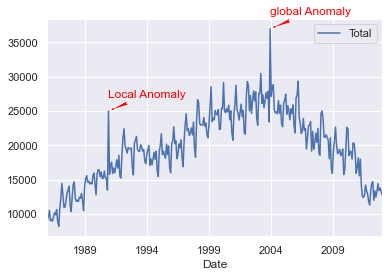

In [8]:
fig, ax = plt.subplots()

catfish_anom.plot(ax=ax)


ax.annotate('Local Anomaly',xy =("1990-12-1", 25000), 
            xytext =("1990-12-1", 27000), color='red',
          arrowprops=dict(facecolor='red',arrowstyle='fancy'))

ax.annotate('global Anomaly',xy =("2003-12-1", 37000), 
            xytext =("2003-12-1", 39000), color='red',
          arrowprops=dict(facecolor='red',arrowstyle='fancy'));

# Importing Birth Dataset

https://jakevdp.github.io/PythonDataScienceHandbook/04.09-text-and-annotation.html

In [9]:
births = pd.read_csv(os.path.join('data','births.csv'))

quartiles = np.percentile(births['births'], [25, 50, 75])
mu, sig = quartiles[1], 0.74 * (quartiles[2] - quartiles[0])
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

births['day'] = births['day'].astype(int)

births.index = pd.to_datetime(10000 * births.year +
                              100 * births.month +
                              births.day, format='%Y%m%d')
births_by_date = births.pivot_table('births',
                                    [births.index.month, births.index.day])
births_by_date.index = [pd.datetime(2012, month, day)
                        for (month, day) in births_by_date.index]

C:\Users\iavta\AppData\Local\Temp/ipykernel_17068/2356623657.py:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  births_by_date.index = [pd.datetime(2012, month, day)


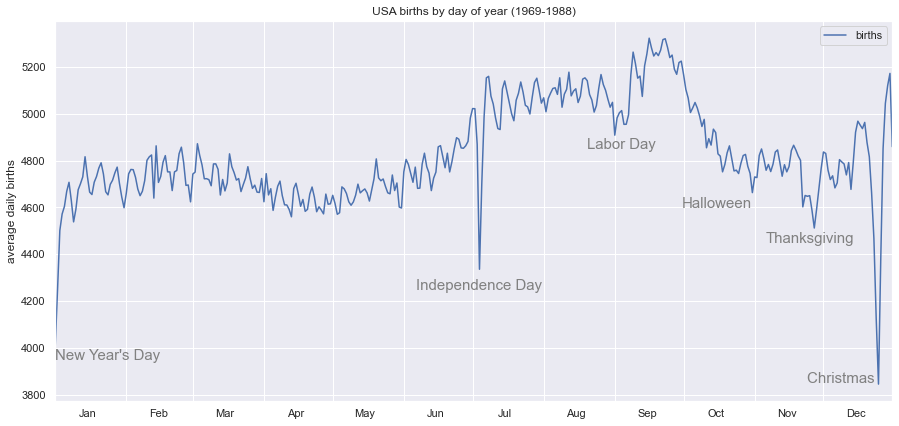

In [10]:
fig, ax = plt.subplots(figsize=(15, 7))
births_by_date.plot(ax=ax)

# Add labels to the plot
style = dict(size=15, color='gray')

ax.text('2012-1-1', 3950, "New Year's Day", **style)
ax.text('2012-7-4', 4250, "Independence Day", ha='center', **style)
ax.text('2012-9-4', 4850, "Labor Day", ha='center', **style)
ax.text('2012-10-31', 4600, "Halloween", ha='right', **style)
ax.text('2012-11-25', 4450, "Thanksgiving", ha='center', **style)
ax.text('2012-12-25', 3850, "Christmas ", ha='right', **style)

# Label the axes
ax.set(title='USA births by day of year (1969-1988)',
       ylabel='average daily births')

# Format the x axis with centered month labels
ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%h'));

# STL decomposition

STL is an acronym for “Seasonal and Trend decomposition using Loess,” while loess is a method for estimating nonlinear relationships. The STL method was developed by R. B. Cleveland et al. (1990)

One advantage of STL decomposition is that it can be robust to outliers (i.e., the user can specify a robust decomposition), so that occasional unusual observations will not affect the estimates of the trend-cycle and seasonal components. They will, however, affect the remainder component.

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

## Catfish data

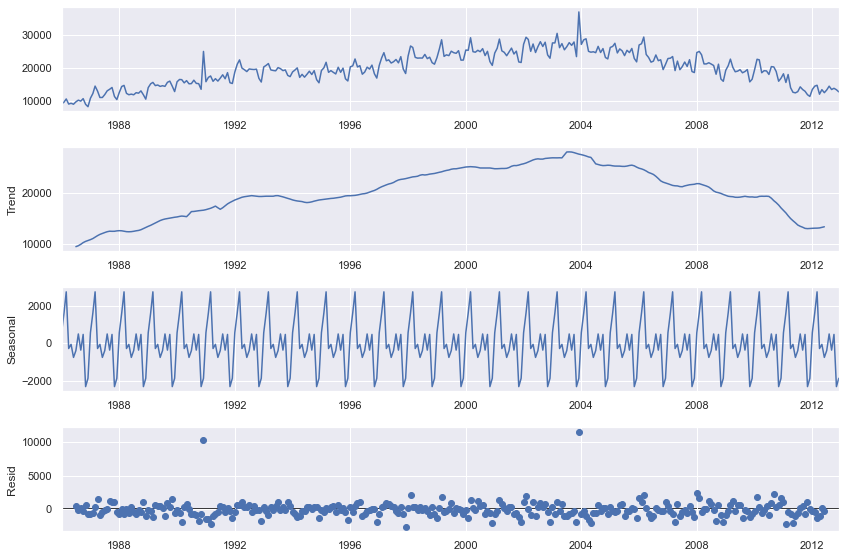

In [12]:
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=15)

result = seasonal_decompose(catfish_anom, model='additive')
fig = result.plot()

Now, we look at the residuals, and check for data points with large deviations.

## Birth data

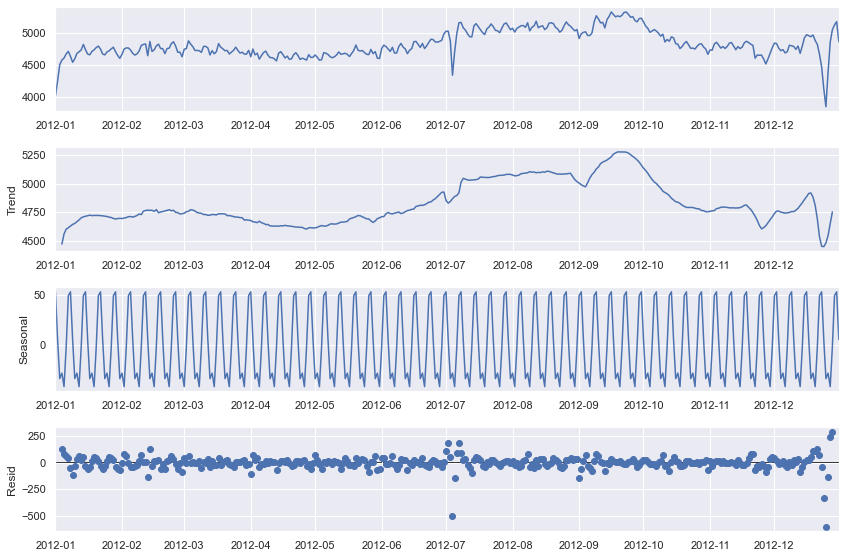

In [13]:
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=15)

result = seasonal_decompose(births_by_date, model='additive')
fig = result.plot()

A real dataset is often much more complex than a synthetic one...

P.s: We lose the outliers at the beginning due to the trend using the initial values, and returning nan.

# Isolation Forest

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
#from sklearn.decomposition import PCA
#from sklearn.cluster import KMeans
#from sklearn.covariance import EllipticEnvelope

## Catfish data

In [15]:
catfish_anom = catfish_sales.copy()
#local
catfish_anom.loc["1990-12-1",'Total'] = 25000

#global
catfish_anom.loc["2003-12-1",'Total'] = 37000

In [16]:
clf = IsolationForest(n_estimators=10, warm_start=True, contamination=.01)
 # fit 10 trees to train data

C:\Users\iavta\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


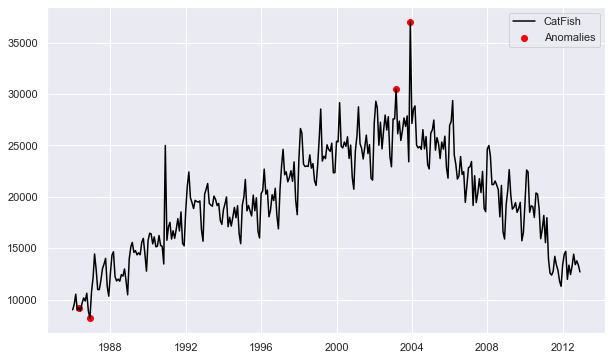

In [17]:
clf.fit(catfish_anom) 
preds = clf.predict(catfish_anom)

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = catfish_anom.loc[preds == -1, 'Total'] #anomaly

ax.plot(catfish_anom.index, catfish_anom['Total'], color='black', label = 'CatFish')
ax.scatter(a.index,a.values, color='red', label = 'Anomalies')
plt.legend()
plt.show();

We can clearly see that the random forest was not able to distinguish the outliers from the min and max values... 

One possibility is to apply this method to the detrended and deseasonalised data. Let's apply it to the STL residuals from the previous method.

In [18]:
STL_catfish = seasonal_decompose(catfish_anom, model='additive')
catfish_resid=STL_catfish.resid.dropna().to_frame()

C:\Users\iavta\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:374: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
C:\Users\iavta\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


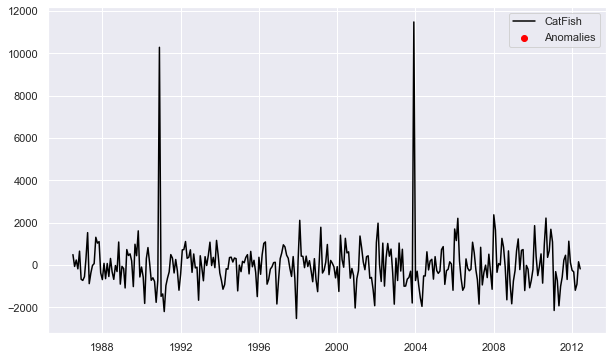

In [19]:
#fitting the model
clf.fit(catfish_resid) 

#predicting the anomalies
preds = clf.predict(catfish_resid)

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = catfish_resid.loc[preds == -1] #anomaly

ax.plot(catfish_resid.index, catfish_resid.values, color='black', label = 'CatFish')
ax.scatter(a.index,a.values, color='red', label = 'Anomalies')
plt.legend()
plt.show();

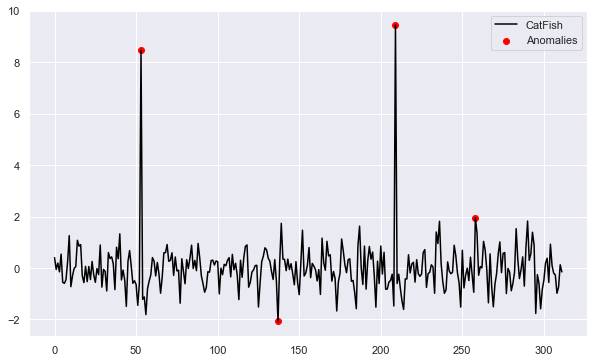

In [20]:
# we could also standardise the residuals. But the results will still be the same...
# could be useful for other models, to improve prediction, or to prevent under/over-flow.
scaler = StandardScaler()
np_scaled = scaler.fit_transform(catfish_resid)
catfish_resid_std = pd.DataFrame(np_scaled)

#Instatiating a model(otherwise we could get strange results)
clf = IsolationForest(n_estimators=20, warm_start=True, contamination=.01)
# fitting the model
clf.fit(catfish_resid_std)

#predicting the anomalies
preds = clf.predict(catfish_resid_std)

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = catfish_resid_std.loc[preds == -1] #anomaly

ax.plot(catfish_resid_std.index, catfish_resid_std.values, color='black', label = 'CatFish')
ax.scatter(a.index,a.values, color='red', label = 'Anomalies')
plt.legend()
plt.show();

## Birth data

C:\Users\iavta\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


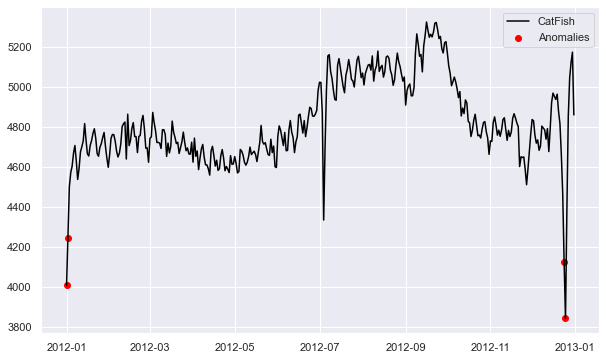

In [21]:
clf = IsolationForest(n_estimators=20, warm_start=True, contamination=.01)

clf.fit(births_by_date) 
preds = clf.predict(births_by_date)

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = births_by_date.loc[preds == -1] #anomaly

ax.plot(births_by_date.index, births_by_date.values, color='black', label = 'CatFish')
ax.scatter(a.index,a.values, color='red', label = 'Anomalies')
plt.legend()
plt.show();

In [22]:
STL_birth = seasonal_decompose(births_by_date, model='additive')
birth_resid=STL_birth.resid.dropna().to_frame()

C:\Users\iavta\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


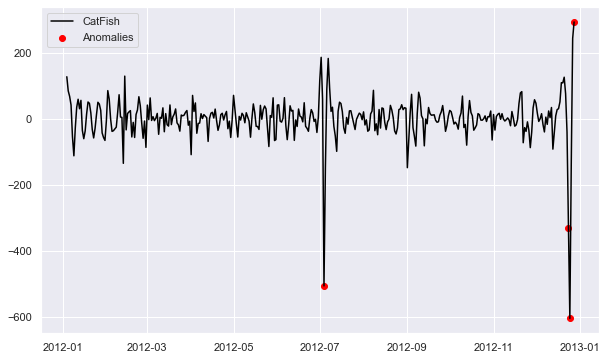

In [23]:

clf = IsolationForest(n_estimators=20, warm_start=True, contamination=.01)
#fitting the model
clf.fit(birth_resid) 

#predicting the anomalies
preds = clf.predict(birth_resid)

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = birth_resid.loc[preds == -1] #anomaly

ax.plot(birth_resid.index, birth_resid.values, color='black', label = 'CatFish')
ax.scatter(a.index,a.values, color='red', label = 'Anomalies')
plt.legend()
plt.show();

We've lost the first outliers due to the trend estimation...

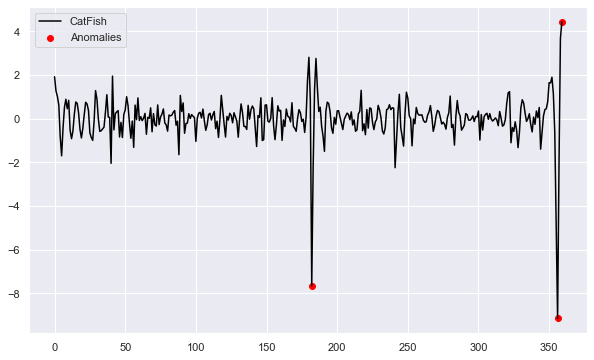

In [24]:
clf = IsolationForest(n_estimators=20, warm_start=True, contamination=.01)
#fitting the model

# we could also standardise the residuals
scaler = StandardScaler()
np_scaled = scaler.fit_transform(birth_resid)
birth_resid_std = pd.DataFrame(np_scaled)

# fitting the model
clf.fit(birth_resid_std)

#predicting the anomalies
preds = clf.predict(birth_resid_std)

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = birth_resid_std.loc[preds == -1] #anomaly

ax.plot(birth_resid_std.index, birth_resid_std.values, color='black', label = 'CatFish')
ax.scatter(a.index,a.values, color='red', label = 'Anomalies')
plt.legend()
plt.show();

## ToDo: Facebook Prophet Model

# Multivariate Time-Series

# Importing Expedia Hotel Searches

You can refer to www.expedia.com to better understand hotel search.

“Hotel” refers to hotels, apartments, B&Bs, hostels and other properties appearing on Expedia’s websites.  Room types are not distinguished and the data can be assumed to apply to the least expensive room type.

Most of the data are for searches that resulted in a purchase, but a small proportion are for searches not leading to a purchase.

In [31]:
hotels = pd.read_csv(os.path.join("data",'TimeSeriesExpedia.csv'))

In [38]:
data = hotels[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]

In [67]:
preds.shape, data.iloc[:,0].shape

((54,), (54,))

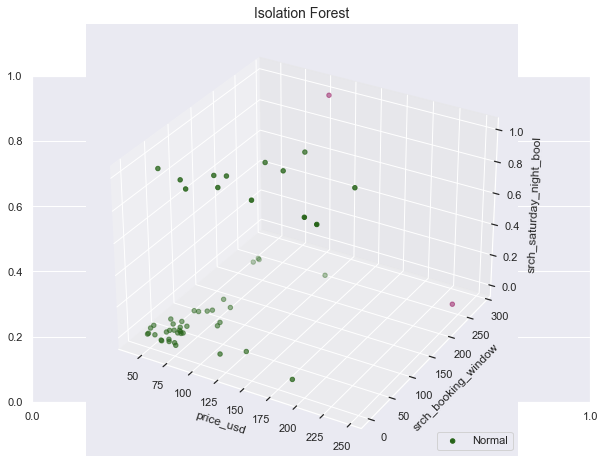

In [77]:
clf = IsolationForest(n_estimators=20, warm_start=True, contamination=.03)
# fitting the model
clf.fit(data.values) 

# predicting the anomalies
preds = clf.predict(data.values)

# Plotting
fig,ax = plt.subplots(figsize=(10,6))
ax =  Axes3D(fig)
ax.scatter(data.iloc[:,0], data.iloc[:,1], data.iloc[:,2],
          c=preds,cmap='PiYG')
ax.set_xlabel("price_usd")
ax.set_ylabel("srch_booking_window")
ax.set_zlabel("srch_saturday_night_bool")

plt.legend(["Normal","Anomalies"], loc = "lower right")

#ax.annotate('Local Anomaly',xy =(), 
#            xytext =("1990-12-1", 27000), color='red',
#          arrowprops=dict(facecolor='red',arrowstyle='fancy'))


plt.title("Isolation Forest", fontsize=14)
plt.show();

In pink, we have the outliers.
 
To use the Kmeans, we could do the following:
 
+ Calculate all the distances
+ Use the fraction of anomalies to obtain the number of anomalies(=n_anom) in the data
+ From the greatest n_anom farthest points from each cluster center, take the minimum as the threshold.
+ Label the data points farther than the threshold as anomalies.